<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style="border:2px solid black"> </hr>

- **What?** SVM buy or sell strategy

# Imports
<hr style="border:2px solid black"> </hr>

In [1]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip install TA-lib
import talib as ta

# Load data
<hr style="border:2px solid black"> </hr>

In [2]:
Df = pd.read_csv('../datasource/random_stock_data.csv')
Df.head(30)

,Time,Open,High,Low,Close,Volume
0,09:15:59,319.25,319.40,316.05,317.70,143354
1,09:16:59,317.70,318.20,317.70,318.00,52695
2,09:17:59,318.00,318.85,318.00,318.55,47179
3,09:18:59,318.65,319.40,318.50,319.20,44745
4,09:19:59,319.30,319.85,319.20,319.65,57892
5,09:20:59,319.60,320.40,319.60,320.25,67482
6,09:21:59,320.25,320.30,319.95,320.05,56590
7,09:22:59,320.15,320.15,319.60,319.60,52413
8,09:23:59,319.65,319.65,319.15,319.40,56305
9,09:24:59,319.50,320.05,319.45,319.70,36525


# EDA
<hr style="border:2px solid black"> </hr>

In [3]:
# Drop the rows with 0 volume traded
Df = Df.drop(Df[Df['Volume']==0].index)

In [4]:
# Convert the 'Time' column into pandas datetime format
Df['Time'] = pd.to_datetime(Df['Time'])

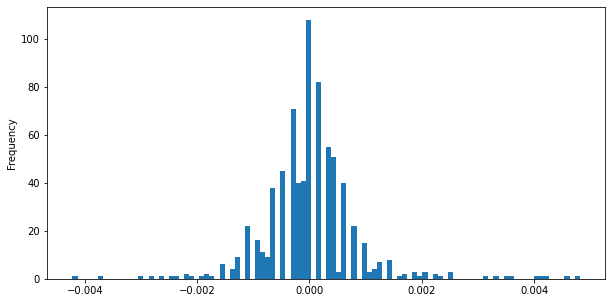

In [5]:
Df['Close'].pct_change().plot(kind='hist', bins=100, figsize=(10, 5));

# Features engineering - indicators
<hr style="border:2px solid black"> </hr>

- **Relative Strength Index (RSI)** The RSI provides technical traders with signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset’s price.
- **Simple Moving Average (SMA)** s an arithmetic moving average calculated by adding recent prices and then dividing that figure by the number of time periods in the calculation average. 
- **The parabolic SAR (stop and reversal)** is a technical indicator used to determine the price direction of an asset, as well as draw attention to when the price direction is changing. Sometimes known as the "stop and reversal system". 
- **Average Directional Index (ADX)**  makes use of a positive (+DI) and negative (-DI) directional indicator in addition to the trendline. The trend has strength when ADX is above 25; the trend is weak or the price is trendless when ADX is below 20, 


In [6]:
# Create a variable n with a value of 10 = 10 Minutes
n = 10

In [7]:
# Create a column by name, RSI and assign the calculation of RSI to it
Df['RSI'] = ta.RSI(np.array(Df['Close'].shift(1)), timeperiod=n)

In [8]:
# Create a column by name, SMA and assign the SMA calculation to it
Df['SMA']= Df['Close'].shift(1).rolling(window=n).mean()

# Create a column by name, Corr and assign the calculation of correlation to it
Df['Corr']= Df['Close'].shift(1).rolling(window=n).corr(Df['SMA'].shift(1))

In [9]:
# Create a column by name, SAR and assign the SAR calculation to it
Df['SAR']=ta.SAR(np.array(Df['High'].shift(1)),np.array(Df['Low'].shift(1)),\
                  0.2,0.2)

# Create a column by name, ADX and assign the ADX calculation to it
Df['ADX']=ta.ADX(np.array(Df['High'].shift(1)),np.array(Df['Low'].shift(1)),\
                  np.array(Df['Open']), timeperiod =n)

We will pass yesterday's "High", "Low", and "Open" prices as input to the algorithm in variables named in lower cases. This will help the algorithm sense the volatility of the past time period.

In [10]:
# Create columns 'high', 'low' and 'close' with previous day's OHLC data
Df['high'] = Df['High'].shift(1)
Df['low'] = Df['Low'].shift(1)
Df['close'] = Df['Close'].shift(1)

We will also create two more columns as features: the change in "Open" prices between yesterday and today & the difference between today's "Open" and yesterday's "Close" prices.

In [11]:
# Create columns 'OO' with the difference between today's open and previous day's open 
Df['OO'] = Df['Open']-Df['Open'].shift(1)

# Create columns 'OC' with the difference between today's open and previous day's close 
Df['OC'] = Df['Open']-Df['close']

In [12]:
# Create a column 'Ret' with calculation of returns
Df['Ret'] = (Df['Open'].shift(-1)-Df['Open'])/Df['Open']

# Create n columns and assign   
for i in range(1,n):
    Df['return%i'%i] = Df['Ret'].shift(i)

# Clean/trim the data
<hr style="border:2px solid black"> </hr>

You need to keep the values of indicator 'Corr' between -1 and 1, as the correlation coefficient is always between these values. This is done by changing all values less than -1 to -1, and all values greater than 1 to 1.

This doesn't affect our calculations negatively because the extreme values are realised due to NAN values in the data, which need to be handled before training the algorithm. Then we drop all NANs from the entire dataframe.

In [13]:
# Change the value of 'Corr' to -1 if it is less than -1
Df.loc[Df['Corr']<-1,'Corr'] = -1

# Change the value of 'Corr' to 1 if it is greater than 1
Df.loc[Df['Corr']>1,'Corr'] = 1

# Drop the NAN values
Df=Df.dropna()

In [14]:
Df

,Time,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,...,Ret,return1,return2,return3,return4,return5,return6,return7,return8,return9
20,2023-07-08 09:35:59,317.90,318.20,317.60,317.80,29910,43.095793,318.850,0.816229,319.184400,...,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,0.002037,0.002199
21,2023-07-08 09:36:59,317.80,317.85,317.40,317.40,21161,41.910041,318.795,0.871812,318.917520,...,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,0.002037
22,2023-07-08 09:37:59,317.40,318.15,317.25,318.00,20039,37.343463,318.630,0.919286,318.654016,...,0.002048,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782
23,2023-07-08 09:38:59,318.05,318.65,317.85,318.65,20345,46.973248,318.465,0.892114,318.403213,...,0.001886,0.002048,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252
24,2023-07-08 09:39:59,318.65,319.00,318.10,318.25,86988,55.251655,318.380,0.616495,317.250000,...,-0.001412,0.001886,0.002048,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,2023-07-08 15:24:59,321.85,321.95,321.70,321.80,57039,71.715070,321.415,0.207479,321.330000,...,-0.000155,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,0.000311,0.000156
745,2023-07-08 15:25:59,321.80,321.95,321.75,321.80,38601,68.057161,321.495,0.619122,321.454000,...,0.000155,-0.000155,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,0.000311
746,2023-07-08 15:26:59,321.85,321.85,321.45,321.55,61275,68.057161,321.560,0.717711,321.553200,...,-0.000777,0.000155,-0.000155,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000
747,2023-07-08 15:27:59,321.60,321.75,321.35,321.45,65368,51.760292,321.595,0.500653,321.950000,...,-0.000466,-0.000777,0.000155,-0.000155,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245


# Train and test data
<hr style="border:2px solid black"> </hr>

We will be using 80% of the data to train and the rest 20% to test. To do this, you will create a split parameter which will divide the dataframe in an 80-20 ratio.

This can be changed as per your choice, but it is advisable to give at least 70% data as train data for good results. "split" is the integer index value for the row corresponding to test-train split. 

In [15]:
# Create a variable split which is 80% of the length of the Dataframe 
t = .8
split = int(t*len(Df))
split

583

# Create output signals
<hr style="border:2px solid black"> </hr>

Next, assign signal values corresponding to 'returns' that were calculated earlier. To do this, you will split the data into three equal parts, using the split on 'Ret' column. 
1. Highest returns’ quantile is assigned Signal '1' or "Buy".
2. Middle quantile is assigned Signal '0' or 'Do nothing'.
3. Lowest quantile is assigned Signal '-1' or 'Sell'. 

In [16]:
# Create a column by name, 'Signal' and initialize with 0
Df['Signal']=0

# Assign a value of 1 to 'Signal' column for the quantile with highest returns
Df.loc[Df['Ret']>Df['Ret'][:split].quantile(q=0.66),'Signal']=1

# Assign a value of -1 to 'Signal' column for the quantile with lowest returns
Df.loc[Df['Ret']<Df['Ret'][:split].quantile(q=0.34),'Signal']=-1

In [17]:
# Assign a value of 0 to 'Signal' column at 1529 time
Df.loc[(Df['Time'].dt.hour==15) & (Df['Time'].dt.minute==29), 'Signal']=0        

# Assign a value of 0 to 'Ret' column at 1529 time
Df.loc[(Df['Time'].dt.hour==15) & (Df['Time'].dt.minute==29), 'Ret']=0

# Create features and target
<hr style="border:2px solid black"> </hr>

Drop the columns 'Close', 'Signal', 'Time', 'High', 'Low', 'Volume', and 'Ret' since the algorithm will not be trained on these features. Next, we assign 'Signal' to 'y' which is the output variable that you will predict using test data.   

In [18]:
# Use df.drop() to drop the columns
X = Df.drop(['Close', 'Signal', 'Time', 'High', 'Low', 'Volume', 'Ret'],axis=1)

# Create a variable which contains all the 'Signal' values
y = Df['Signal']

In [19]:
# Plot them together
pd.concat([X,y], axis=1)

,Open,RSI,SMA,Corr,SAR,ADX,high,low,close,OO,...,return1,return2,return3,return4,return5,return6,return7,return8,return9,Signal
20,317.90,43.095793,318.850,0.816229,319.184400,13.793519,318.30,317.85,317.90,-0.35,...,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,0.002037,0.002199,-1
21,317.80,41.910041,318.795,0.871812,318.917520,15.563131,318.20,317.60,317.80,-0.10,...,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,0.002037,-1
22,317.40,37.343463,318.630,0.919286,318.654016,17.581703,317.85,317.40,317.40,-0.40,...,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,1
23,318.05,46.973248,318.465,0.892114,318.403213,18.123915,318.15,317.25,318.00,0.65,...,0.002048,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,1
24,318.65,55.251655,318.380,0.616495,317.250000,16.790058,318.65,317.85,318.65,0.60,...,0.001886,0.002048,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,321.85,71.715070,321.415,0.207479,321.330000,22.193076,321.95,321.70,321.85,0.15,...,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,0.000311,0.000156,0
745,321.80,68.057161,321.495,0.619122,321.454000,22.674351,321.95,321.70,321.80,-0.05,...,-0.000155,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,0.000311,0
746,321.85,68.057161,321.560,0.717711,321.553200,23.107498,321.95,321.75,321.80,0.05,...,0.000155,-0.000155,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,-1
747,321.60,51.760292,321.595,0.500653,321.950000,21.483583,321.85,321.45,321.55,-0.25,...,-0.000777,0.000155,-0.000155,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,-1


## Find best parameters

### Pipeline and functions

As the very first step to finding the best hyperparameters among C, Gamma and Kernel, you will first create a pipeline of functions which are required to run in a certain order on the training data. 

The ‘steps’ contains references to functions that would be applied to the data when called through a pipeline function. In this case, you will scale the data first and then fit it to the SVC function. This is done to avoid the effect of the individual weights of the features.

In [20]:
# Create the 'steps' variable with the pipeline functions
steps = [('scaler', StandardScaler()), ('svc', SVC())]

# Pass the 'steps' to the Pipeline function
pipeline = Pipeline(steps)

### Hyperparameters

The hyperparameters are iterated over to arrive at the best possible combination for the given training data. These test values can be changed as per your choice. Here, you will choose 4 test values for 'c' and 3 test values for 'g'.  

In [21]:
# Test variables for 'c' and 'g'
c = [10,100,1000,10000]
g = [1e-2,1e-1,1e0]

The 'rbf' is used as a singular entry in the kernel parameters. But you can go ahead and try other kernel functions, such as linear, poly and sigmoid.

<b>Do remember:</b> A higher number of parameters would result in a greater time for the code to run. 

In [22]:
# Intialize the parameters
parameters = {'svc__C':c,
              'svc__gamma':g,
              'svc__kernel': ['rbf', 'poly', 'sigmoid']
             }

Next, you need to create a RandomizedSearchCV function with a cross validation value of 7. This value can be anything more than or equal to 3. The concept of cross validation is used to arrive at the scores of different random combinations of the hyperparameters.

These scores would be used to find the best parameters and create a newly optimized support vector classifier.

In [23]:
# Call the RandomizedSearchCV function and pass the parameters 
rcv = RandomizedSearchCV(pipeline, parameters, cv=7) #, iid=False)

### Training on and fetching the best parameters
             
Next, you need to fit the train data to 'rcv' created above to obtain the best hyperparameters. The best parameters can be obtained using the best_params function.

In [24]:
# Call the 'fit' method of rcv and pass the train data to it 
rcv.fit(X.iloc[:split],y.iloc[:split])

# Call the 'best_params_' method to obtain the best parameters of C
best_C = rcv.best_params_['svc__C']

# Call the 'best_params_' method to obtain the best parameters of kernel
best_kernel = rcv.best_params_['svc__kernel']

# Call the 'best_params_' method to obtain the best parameters of gamma
best_gamma = rcv.best_params_['svc__gamma']

In [25]:
best_C

100

In [26]:
best_kernel

'rbf'

In [27]:
best_gamma

0.1

## Create the Support Vector Machine

In this line of code we instantiate a new support vector classifier function with the best hyperparameters.

In [28]:
# Create a new SVC classifier
cls = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)

### Train the data

As done previously, for finding the best hyperparameters, you will first scale the data before you fit it to the classifier to train on. To do this, you need to first instantiate the Standard Scaler function.

In [29]:
# Instantiate the StandardScaler 
ss1 = StandardScaler()

You will use the scaled training data to train the classifier algorithm.

In [30]:
# Pass the scaled train data to the SVC classifier
# please note we are doing out-of-time (prediction) on unseen data
cls.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Predict the signals

Now, you can use the test data to make predictions and save the value of output 'y' in a list called 'y_predict'. This list will have the predicted values of 'Signal' for the test data.  

In [31]:
# Pass the test data to the predict function and store the values into 'y_predict' 
y_predict = cls.predict(ss1.transform(X.iloc[split:]))

Now create a new column 'Pred_Signal' in 'Df' to save all the predictions for both train data and test data.

In [32]:
# Initiate a column by name, 'Pred_Signal' and assign 0 to it
Df['Pred_Signal'] = 0

### Save the predictions
1. To save predicted 'y' values of test data, we can simply assign 'y_predict' to 'Pred_Signal' using the split.
2. To save predicted 'y' values for train data, we make predictions for train data and save it similarly.

In [33]:
# Save the predicted values for the train data
Df.iloc[:split,Df.columns.get_loc('Pred_Signal')] = pd.Series(cls.predict(ss1.transform(X.iloc[:split])).tolist())

# Save the predicted values for the test data
Df.iloc[split:,Df.columns.get_loc('Pred_Signal')] = y_predict

Since, the algorithm was trained on the train data, it’s accuracy of prediction is expected to be better on this train data compared to the test data. You can print these two seperately to check the accuracies. (TRY ON YOUR OWN!)

## Use the model for trading strategy 

### Trading strategy 
        
Our trading strategy is simply to buy/sell/do-nothing at that period for which the Signal is generated by the algorithm. The strategy assumes that you always get a fill at the "Open" prices. 

You had already calculated and saved returns on 'Open' prices in 'Ret'. You will create a column named 'Ret1' to store the strategy's returns based on the Signal.

In [34]:
# Calculate strategy returns and store them in 'Ret1' column 
Df['Ret1'] = Df['Ret']*Df['Pred_Signal'] 

## Analyze the performance

Please note that here you are using only the test data to compare the performance of the strategy. You can pass the entire 'Ret1' column and check the performance on both the test and train data if you wish to.

In [35]:
# Calculate the annualized Sharpe ratio
sharpe = np.sqrt(252) * Df['Ret1'][split:].mean() / Df['Ret1'][split:].std()

print('Sharpe', sharpe)

Sharpe 2.906475436727308


## Plot the results

Now you can plot the results to visualize the performance.


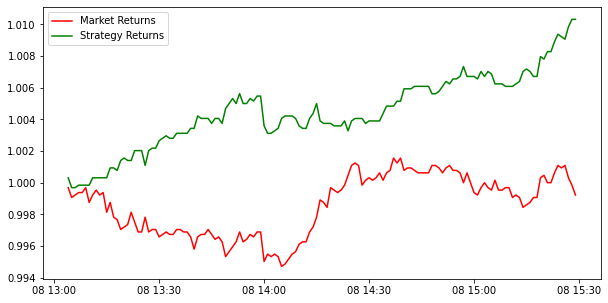

In [36]:
Df.set_index("Time", inplace=True)
# Plot the stretegy returns
plt.figure(figsize=(10,5))
plt.plot(((Df['Ret'][split:]+1).cumprod()),color='r',label='Market Returns')
plt.plot(((Df['Ret1'][split:]+1).cumprod()),color='g',label='Strategy Returns')
plt.legend()
plt.show()

# References
<hr style="border:2px solid black"> </hr>

- https://github.com/Datatouille/findalpha/tree/master